## Etude du son de la flute

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import IPython.display

In [3]:
fe, data = scipy.io.wavfile.read('fluteircam.wav')
length = data.shape[0] / fe
time = np.linspace(0., length, data.shape[0])

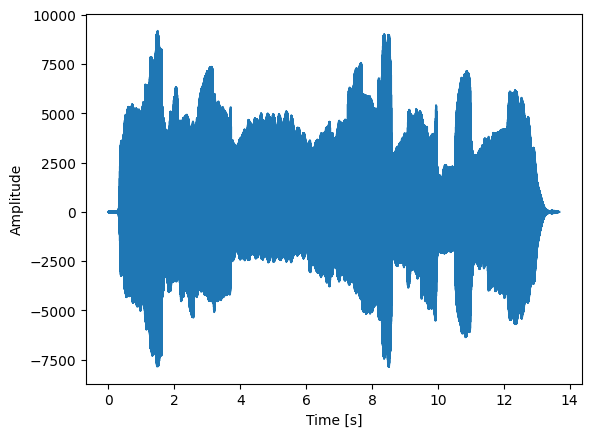

In [4]:
plt.plot(time, data, label="Flute signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
IPython.display.Audio(data, rate = fe)

In [5]:
T=0.04 # durée de stationnarité des signale sonores
N = round(T*fe)
t = np.array(range(-N+1,N-1))/fe;

decalage = 0.01
ND = round(decalage*fe);

### Détection de $f_0$ avec la FFT

425.665101721439

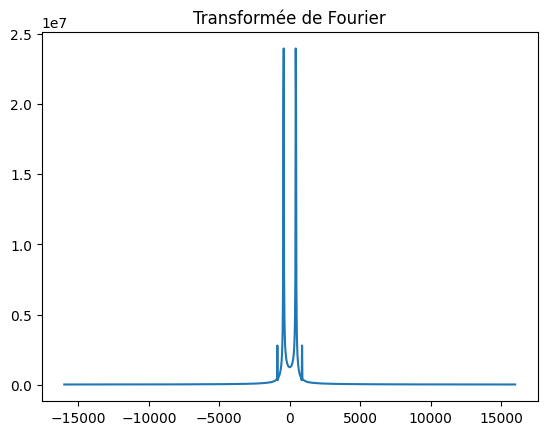

In [6]:
def calcul_freq_fft(indice_tram,plot_figure):

    x = data[1+int(indice_tram)*ND:N+int(indice_tram)*ND]
    window = scipy.signal.windows.barthann(51,sym=True)

    x = scipy.signal.convolve(x,window,mode='same')
    X = scipy.fft.fft(x)

    XP = scipy.fft.fftshift(np.abs(X))

    XP_mean = XP[XP>XP.mean()]

    peaks, _ = scipy.signal.find_peaks(XP_mean)


    freq = np.linspace(-fe/2,fe/2,len(XP))
    
    if plot_figure:
        plt.title("Transformée de Fourier")
        plt.plot(freq, XP)

    f0 = max(freq[np.argwhere(XP==max(XP))])[0]
    
    return f0
calcul_freq_fft(40,True)

In [7]:

def calcul_bonne_freq_fft():

    tram = [i for i in range(0,round(data.shape[0]/ND),10)]
    bonne_tram = []

    for indice_tram in tram:
        x = data[1+int(indice_tram)*ND:N+int(indice_tram)*ND]
        window = scipy.signal.windows.barthann(51,sym=True)

        x = scipy.signal.convolve(x,window,mode='same')
        X = scipy.fft.fft(x)

        XP = scipy.fft.fftshift(np.abs(X))

        peaks, _ = scipy.signal.find_peaks(XP)
        sorted_peaks = sorted(XP[peaks])[::-1]

        freq = np.linspace(-fe/2,fe/2,len(XP))

        f0 = max(freq[np.argwhere(XP==max(XP))])[0]
    
        if sorted_peaks[0]>2*sorted_peaks[2]:    
            bonne_tram.append(np.array([indice_tram,f0]))
        
    return np.array(bonne_tram)

bonne_tram = calcul_bonne_freq_fft()
pourcentage = len(bonne_tram)/137*100
print("Le pourcentage de bonnes trames est : {:.2f}".format(pourcentage))


Le pourcentage de bonnes trames est : 93.43


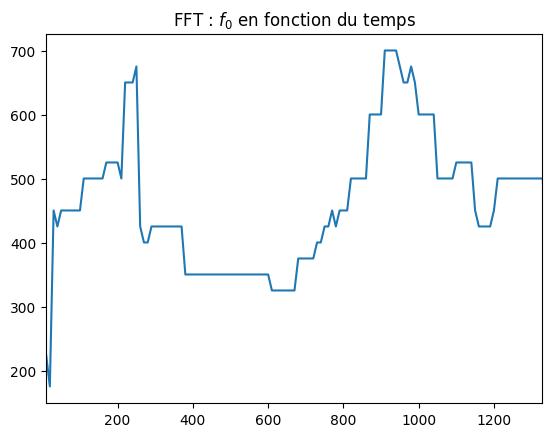

In [8]:
def trace_f0_fft_flute():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        f0 = calcul_freq_fft(indice_tram,False)
        f0_list.append(np.array([indice_tram,f0]))
    f0_list = np.array(f0_list)
    # plt.ylim(0,800)
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.title("FFT : $f_0$ en fonction du temps")
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.show()

trace_f0_fft_flute()

### Détection de $f_0$ avec l'autocorrélation

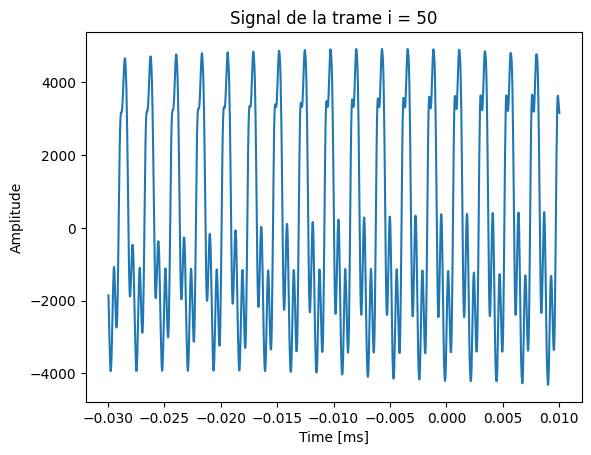

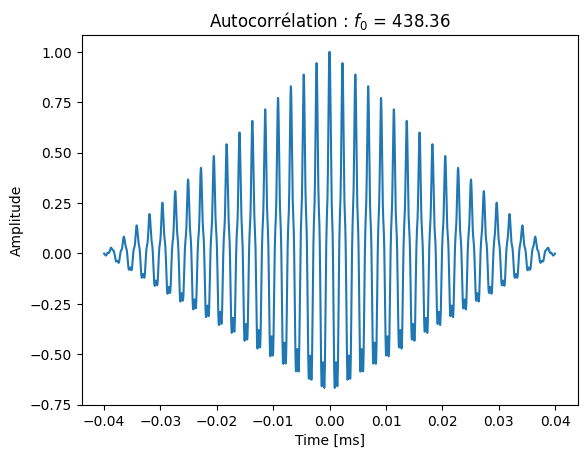

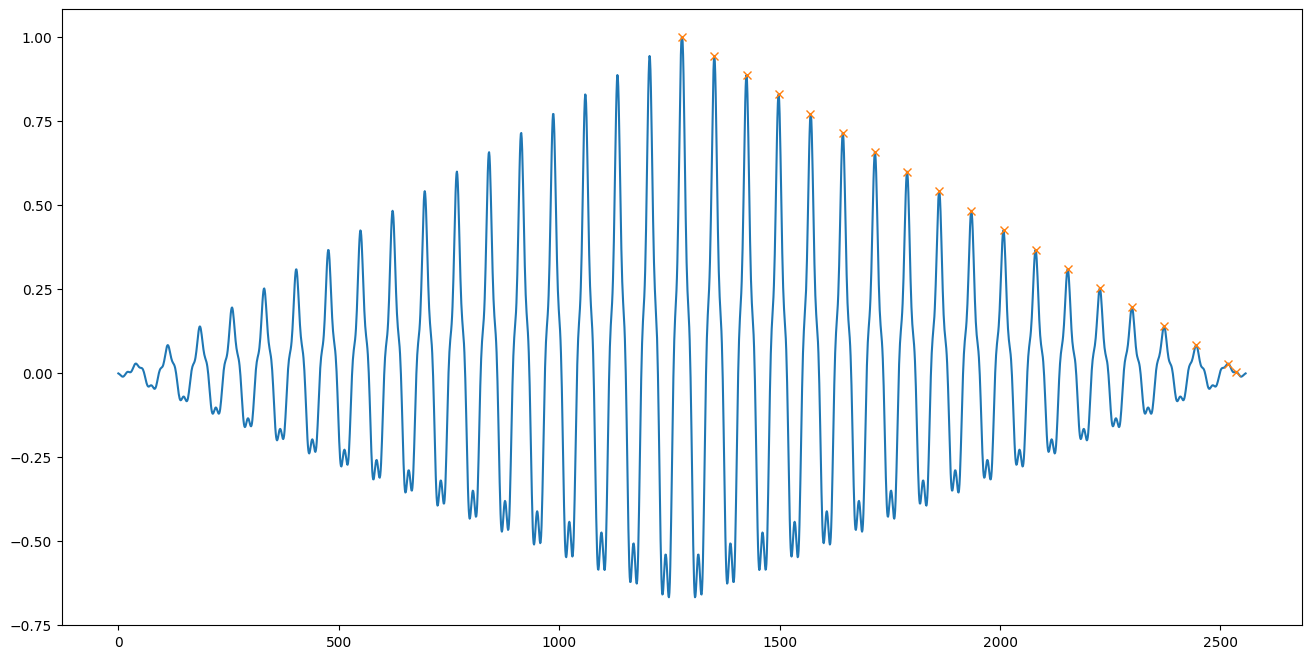

(0.0006571220103639897, 438.3561643835617)

In [9]:
def calcul_freq_xcor(indice_tram,plot):
    x = data[1+indice_tram*ND:N+indice_tram*ND]

    

    xcorr = sm.tsa.stattools.ccf(x,x,adjusted=False)
    xcorr = np.concatenate((xcorr[::-1],xcorr))

    
    try:
        peaks,_ =scipy.signal.find_peaks(xcorr)
        sorted_peaks = sorted(xcorr[peaks],reverse=True)

        t0 = t[:len(xcorr)]
        f0 = 1/t0[np.argwhere(xcorr == sorted_peaks[1])]
        f0 = f0[f0>0][0]

        peaks_positive = peaks[np.argwhere(t0[peaks]>=0)].flatten().tolist()
        peaks_positive.append(peaks[np.argwhere(xcorr[peaks]==max(xcorr))].flatten()[0])
        peaks_positive = np.array(peaks_positive)
        peaks_positive = peaks_positive[np.argwhere(xcorr[peaks_positive]>0)].flatten()
        
        
        points = np.array([(t0[i],xcorr[i]) for i in peaks_positive])
        
        # peaks_positive = np.array(peaks_positive)
        
        A0,Ainf = points[0],points[-1]
        vec_dir = A0-Ainf
        angles = []
        for i in range(1,len(points)-3):
            Ai = points[i]
            u,v = Ai-A0, Ai-Ainf
            angle_indice = np.arccos(np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v)))
            angles.append(angle_indice)
        
        angle = max(angles)
        
        if plot:
            plt.plot(t[1+ND:N+ND], x)
            plt.xlabel("Time [ms]")
            plt.ylabel("Amplitude")
            plt.title(f'Signal de la trame i = {indice_tram}')
            plt.show()
        
            plt.plot(t[:len(xcorr)], xcorr)
            plt.xlabel("Time [ms]")
            plt.ylabel("Amplitude")
            plt.title('Autocorrélation : $f_0$ = {:.2f}'.format(f0))
            plt.show()
            
            plt.figure(figsize=(16,8))
            plt.plot(xcorr)
            plt.plot(peaks_positive,xcorr[peaks_positive],'x')
            plt.show()
        
        return angle,f0
    except:
        pass
    
    if plot:
        plt.plot(t[1+ND:N+ND], x)
        plt.xlabel("Time [ms]")
        plt.ylabel("Amplitude")
        plt.title(f'Signal de la trame i = {indice_tram}')
        plt.show()
        
calcul_freq_xcor(50,True)

In [10]:
def calcul_bonne_freq_xcor():
    tram_avec_bonne_freq = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        angle,f0 = calcul_freq_xcor(indice_tram,False)
        # print(angle)
        if round(angle)==0:
            tram_avec_bonne_freq.append((indice_tram,f0))
    return tram_avec_bonne_freq    

In [11]:
tram_avec_bonne_freq = calcul_bonne_freq_xcor()
pourcentage = len(tram_avec_bonne_freq)/137*100
print("Le pourcentage de bonnes trames est : {:.2f}%".format(pourcentage))

Le pourcentage de bonnes trames est : 89.05%


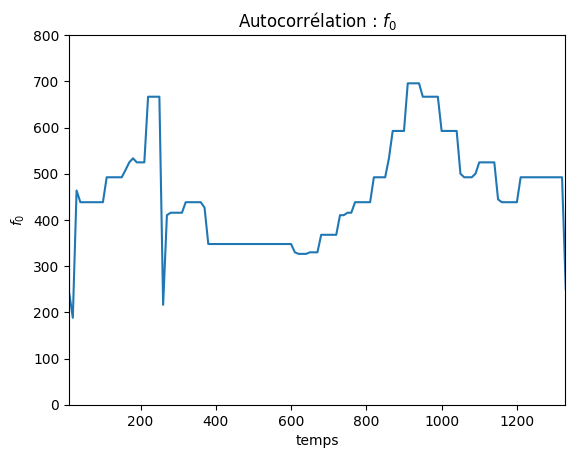

In [12]:
def trace_f0_xcor_flute():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        try:
            angle,f0 = calcul_freq_xcor(indice_tram,False)
            f0_list.append(np.array([indice_tram,f0]))
        except:
            f0_list.append(np.array([indice_tram,0]))
            # pass
    f0_list = np.array(f0_list)
    plt.ylim(0,800)
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.title("Autocorrélation : $f_0$")
    plt.xlabel('temps')
    plt.ylabel('$f_0$')
    plt.show()

trace_f0_xcor_flute() 


### Détection de $f_0$ avec la méthode Burg

In [13]:
def calcul_DSP_burg(coef,sigma):

    term2=2j*np.pi/fe*np.arange(1,4+1)
    term2 = term2.reshape(4,1)
    freq = np.linspace(-fe/2,fe/2,fe)
    freq = freq.reshape(freq.shape[0],1)
    term3=term2@freq.T
    term=1.+coef@np.exp(term3)
    DSP = sigma/(term*np.conj(term))
    DSP = np.abs(DSP)
    return freq,DSP

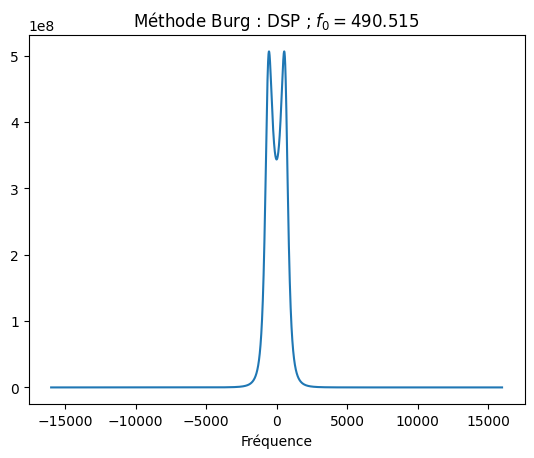

490.5153286040204

In [14]:
def calcul_freq_burg(indice_tram,plot_figure):
    
    x = data[1+indice_tram*ND:N+indice_tram*ND]
    
    window = scipy.signal.windows.barthann(51)
    x_fen = scipy.signal.convolve(x,window,mode='same')


    rho, sigma2 = sm.regression.linear_model.burg(x,4)
    rho_fen, sigma2_fen = sm.regression.linear_model.burg(x_fen,4)
    
    rho = -rho
    rho_fen = -rho_fen

    freq, DSP = calcul_DSP_burg(rho,sigma2)
    freq_fen, DSP_fen = calcul_DSP_burg(rho_fen,sigma2_fen)
    
    
    
    f0 = abs(freq_fen[np.argwhere(DSP_fen==max(DSP_fen))].flatten()[0])
    
    peaks,_ = scipy.signal.find_peaks(DSP_fen)
    
    
    if plot_figure:
        plt.plot(freq,DSP)
        plt.title("Méthode Burg : DSP ; $f_0 = {:.3f}$".format(f0))
        plt.xlabel('Fréquence')
        plt.show()
    
    return f0
    

calcul_freq_burg(150,True)


In [15]:
def calcul_bonne_freq_burg():
    
    
    tram = [i for i in range(0,round(data.shape[0]/ND),10)]
    bonne_tram = []
    
    for indice_tram in tram:
    
        x = data[1+indice_tram*ND:N+indice_tram*ND]
        
        window = scipy.signal.windows.barthann(51)
        x_fen = scipy.signal.convolve(x,window,mode='same')


        rho_fen, sigma2_fen = sm.regression.linear_model.burg(x_fen,4)
        rho, sigma2 = sm.regression.linear_model.burg(x,4)
        rho_fen = -rho_fen

        freq_fen, DSP_fen = calcul_DSP_burg(rho_fen,sigma2_fen)
        freq, DSP= calcul_DSP_burg(rho,sigma2)
        
        f0 = abs(freq_fen[np.argwhere(DSP_fen==max(DSP_fen))].flatten()[0])
        
        peaks,_ = scipy.signal.find_peaks(DSP_fen)
        
        if peaks.shape[0]<4:    
            bonne_tram.append(np.array([indice_tram]))
    return np.array(bonne_tram)
    
        
    
    

bonne_tram_burg = calcul_bonne_freq_burg()

pourcentage = len(bonne_tram_burg)/137*100
print("Le pourcentage de bonnes trames est : {:.2f}".format(pourcentage))

Le pourcentage de bonnes trames est : 29.93


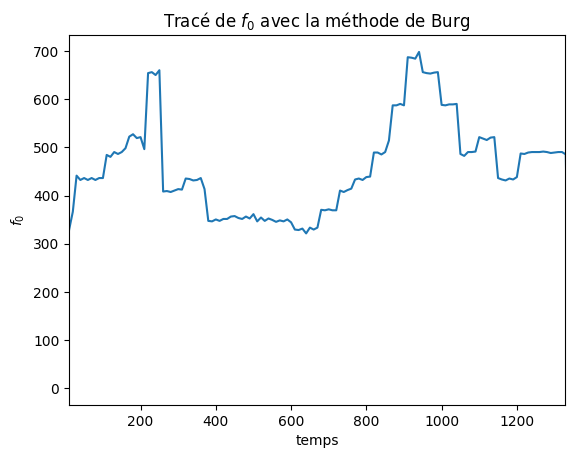

In [16]:
def trace_f0_burg_flute():
    f0_list = []
    for indice_tram in range(0,round(data.shape[0]/ND),10):
        f0 = calcul_freq_burg(indice_tram,False)
        f0_list.append(np.array([indice_tram,f0]))
    f0_list = np.array(f0_list)
    # print(f0_list)
    # plt.ylim(0,800)
    plt.xlim(10,round(data.shape[0]/ND)-40)
    plt.plot(f0_list[:,0],f0_list[:,1])
    plt.title("Tracé de $f_0$ avec la méthode de Burg")
    plt.xlabel('temps')
    plt.ylabel('$f_0$')
    plt.show()
    

trace_f0_burg_flute()